# Analysis for `d1` dataset 
The dataset we are looking at corresponds to the following ligament ensemle - 
- Length scale : $ \sim 1 \textrm{cm}$ ($\textrm{Oh} = 10^{-3}$)
- Initial perturbation strength : $\varepsilon \sim 0.08$
- Aspect-ratio, defined with respect to initial ligament width : $\Lambda = 50$

#### Import libraries
We start by loading the required libraries, and set the plotting styles. 

In [7]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# Required libraries for data arrays, data manipulation, plotting etc
import numpy as np
from useful_functions import *
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (5., 5.)})
sns.set_style("ticks")

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}",r'\boldmath']
#plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data import 

#### Size information
We import a cleaned dataset corresponding to ligament ensemble `d1`. 

In [8]:
data = pd.read_csv("./data/new/paper/data_d1.csv")
data.head().transpose()
print("Total number of datapoints over all slices of time is {}".format(data.shape[0]))

,0,1,2,3,4
time,0.0,2.0,4.0,6.0,8.0
diameter,8.48255,8.55159,8.537,8.5302,8.51828
velocity,NaN,-0.000135,-0.000173,0.00021,0.00012


Total number of datapoints over all slices of time is 906428


#### Drop count as function of time
We also have the total drop count as a function of time. 

In [15]:
ndrops = pd.read_csv("./data/new/paper/ndrops_d1.csv", sep=" ",names=["time","drops"])
ndrops.head(16).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
time,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30
drops,8415,8410,8403,8414,10734,43396,96695,111235,96896,86123,80255,74922,71377,69279,66814,64303


### Breakups vs Coalescence as function of time
Let us look at how the total number of drops vary versus time. This gives us an idea about the point beyond which no more breakups occur, and coalescences dominate the dynamics. 

In order to estimate the number of drops produced per unit length corresponding to the optimal Rayleigh-Plateau wavelength, 
we define a new measure **average drop count** as -

$$ \text{Average Drop Count} = \frac{\text{Total number of drops (across all ligaments)}}{ \text{Total number of RP optimal length units (across all ligaments)}} $$.

The denominator is simply given by $0.7 \times (N\Lambda / \pi)$, where $N$ is the total number of ligaments.

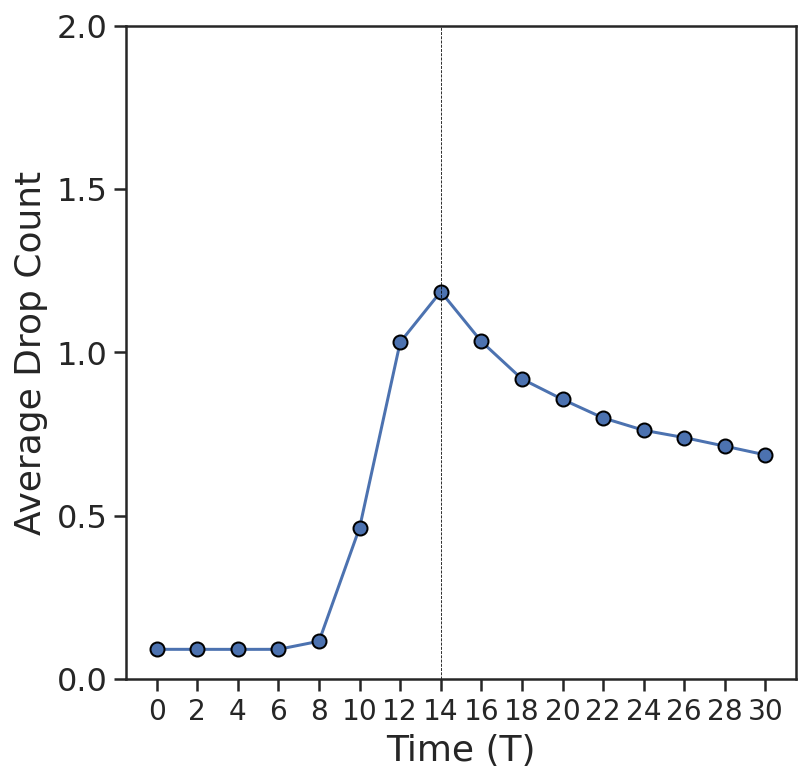

In [24]:
%matplotlib inline

rp_units = (ndrops.loc[0,"drops"] * 0.7 * 50.0)/np.pi
#print(rp_units)
plt.figure(figsize=(6,6));
plt.plot(ndrops['time'], ndrops['drops'] / rp_units, marker = 'o', markersize = '7',
        markeredgecolor = 'black');
plt.axvline(x=14, linewidth=0.4 , color="black", linestyle='--')
plt.xticks(np.arange(0,32,step=2), fontsize=14);
plt.yticks(np.linspace(0,2,5), fontsize=16);
#plt.yscale('log');
plt.ylim(bottom = 0, top=2);
plt.ylabel("Average Drop Count", fontsize = 18);
plt.xlabel("Time (T)", fontsize=18);
#plt.title("Breakup versus Coalescence", fontsize= 16);
#plt.savefig("./plots_paper/drops_vs_time.pdf", dpi=200);

Thus, we can clearly see that the beyond T=14, no more breakups occur. 

### Equivalent Diameters
Let us compute the values for the **equivalent diameters**, which can be simply estimated by equating the volume under our *discrete* wavelengths ($L_i $) to the volume of a drop with diameter $D_i$. Thus we get 

$$ \pi D_i^3 /6 = \pi R^2 L_i \implies D_i = (6 L_i R^2 )^{1/3} $$ 

The $i$ in the above equation refers to the discrete wave number, whose wavelength is given by $L_i = L/i$. We also rescale the the diameters with the intial width of the ligament $W$, thus giving us 

$$ D_i / W = \left(3\Lambda /2i \right)^{1/3} \,. $$

### Rayleigh-Plateau unstable wavelengths

Now, setting $i=1$, we get the maximum possible equivalent diameter, which is the case if the entire ligament collapsed into a single drop.
The shortest wavelength which is unstable with respect to Rayleigh-Plateau is given by 

$$ i \approx \Lambda/\pi \quad \implies D_\textrm{short}/W \approx 1.68 \,.$$ 

For the optimal (largest growth rate) wavelength of the Rayleigh-Plateau instability, we have 

$$ i \approx 0.7 \Lambda/\pi \quad \implies D_\textrm{rp}/W \approx 1.89 \,.$$ 

> $\Lambda = 50$ for `d1` dataset. 

### Key $D/W$ values
 
Therefore, we have several interesting values for the equivalent diameters as follows 
- $D_\textrm{max}/W \approx 4.21$ : Largest wavelength for the $\Lambda =50$ (entire ligament) .
- $D_\textrm{rp}/W \approx 1.89$ : Wavelength corresponding to optimal growth rate of Rayleigh-Plateau instability.
- $D_\textrm{short}/ W \approx 1.68$ : Shortest unstable wavelength for Rayleigh-Plateau instability.
- $D_\textrm{cut}/W \approx 1.14 $: Cut-off wavelengths set by low-pass filter for the $\Lambda =50$.


We also have to take into account the size of drops that form after a coalescence event. We assign the important values of $D/W$ computed above to some variables, and also define a function that computes the diameter of a drop formed due to coalescence of two drops. 

## Drop size distributions

We take a look at the drop size PDF at T=14. 

### Linear scale histogram

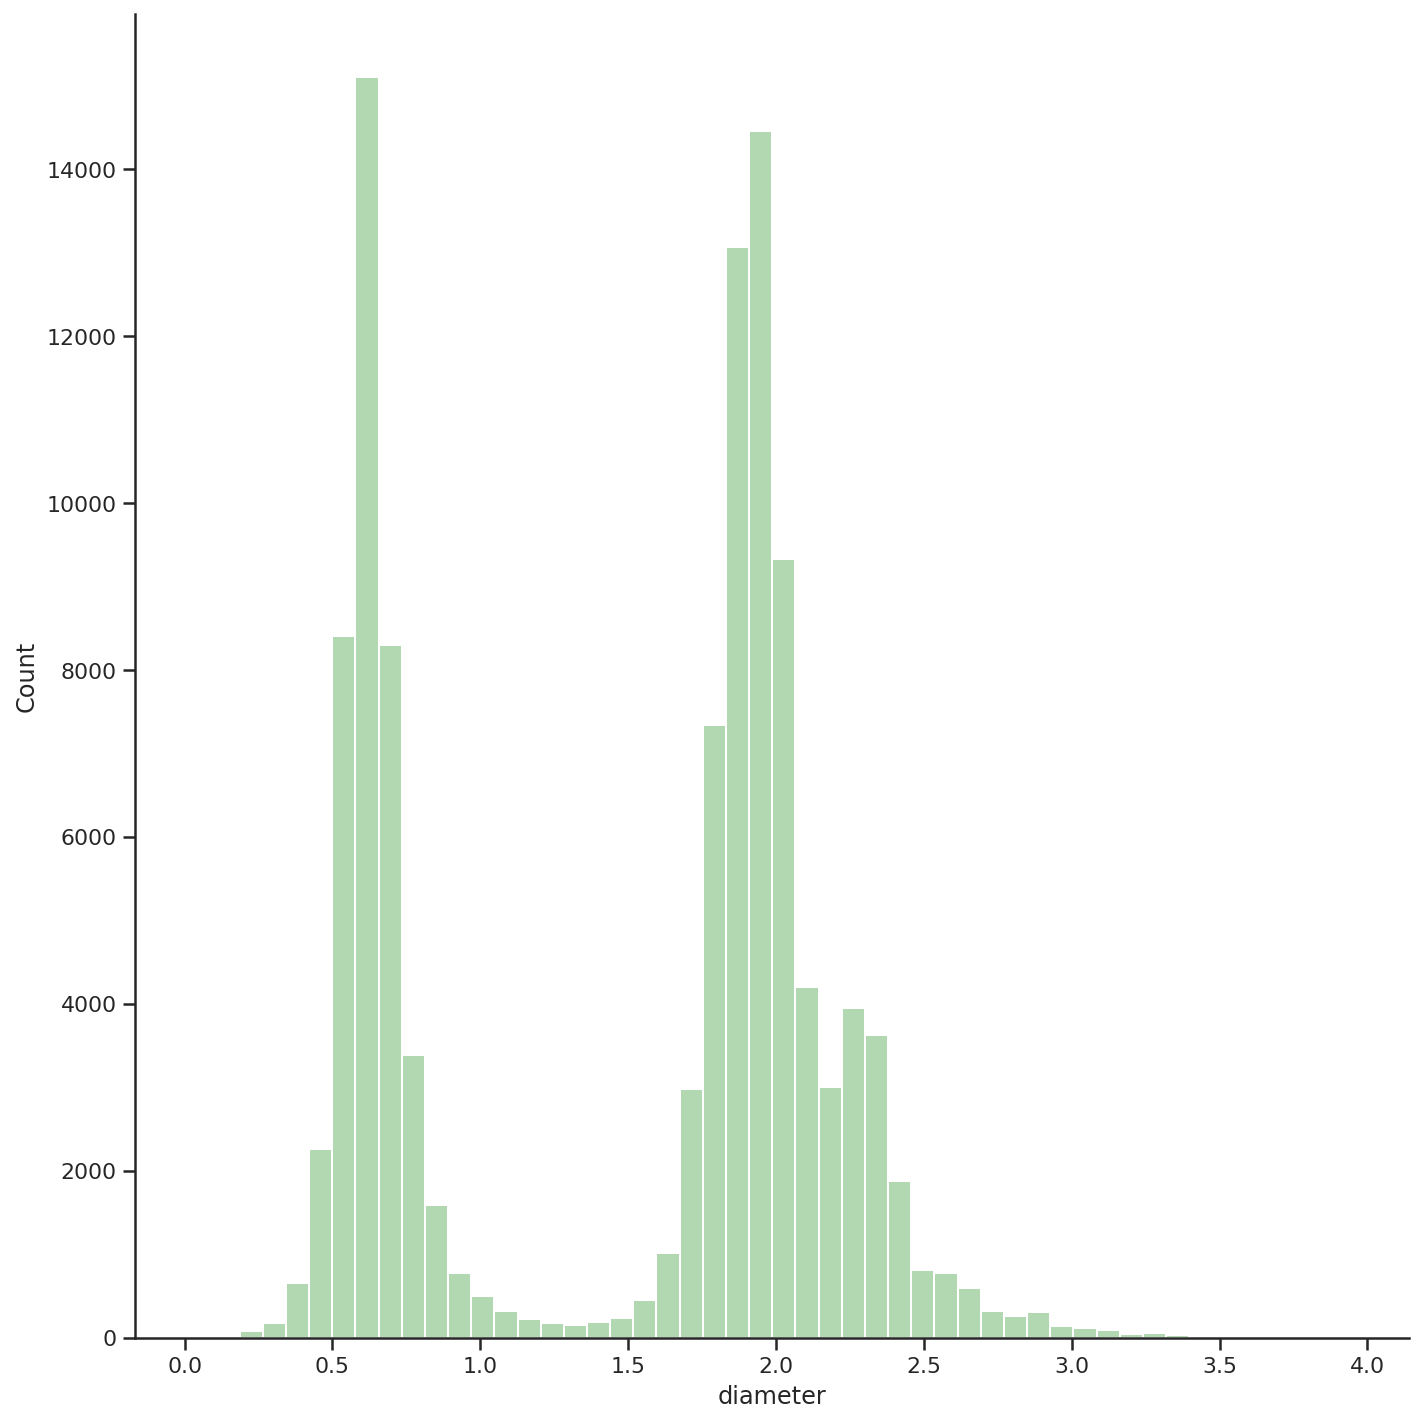

In [30]:
#display(Image(filename="../d1/img-snapshot-16.png"))
time_slice = 14
bins = 50

sns.displot(data=data.diameter[(data.time == time_slice)].map(lambda p: p/2.0), kind="hist", kde=False,
            legend=True, palette="bright", height=10.0, aspect=1.0,
           alpha = 0.3 , color = 'green', bins = bins) ;

#plt.ylim(top = 18000);

> We observe these peaks at $D/W \approx 1.89$ and $D/W \approx 0.6$ respectively). 

What happends when we observe the distribution once a few coalescences have occured ? 

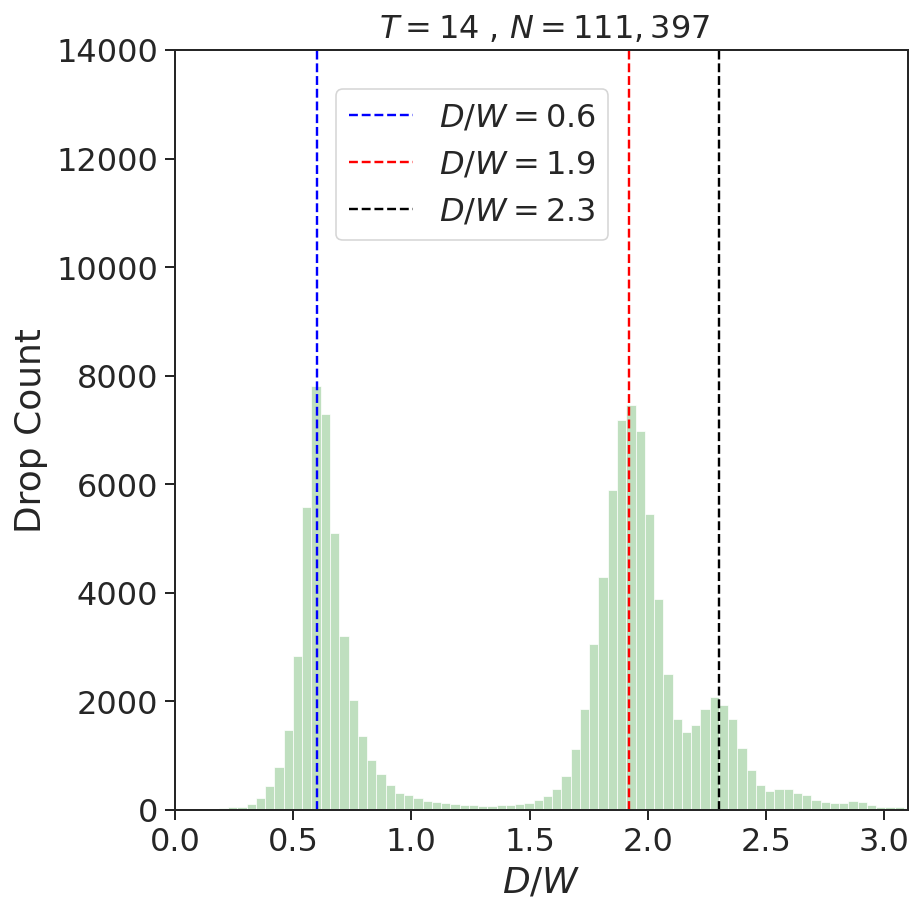

In [34]:
#from IPython.display import Image, display
#display(Image(filename="../d3/img-snapshot-14.png"))


#list_of_images = ["../d1/img-snapshot-16.png",
#                    "../d1/img-snapshot-18.png",
#                    "../d1/img-snapshot-20.png",
#                    "../d1/img-snapshot-22.png"]
#for dummy in list_of_images:
#    display(Image(filename=dummy))
sns.set_context("paper")
sns.set_style("ticks")

time_slice = 14
bins = 100

lim_1 = 0.6
lim_2 = 1.92
lim_3 = 2.3


a = sns.displot(data=data.diameter[(data.time == time_slice)].map(lambda p: p/2.0), kind="hist", kde=False,
            legend=True, height=6.0, aspect=1.0, alpha = 0.25 , color = 'green', bins = bins) ;


# satellite drop
plt.axvline(x= lim_1, color = 'blue', linestyle='--', label="$D/W = %.1f$" %lim_1, lw = 1.2);

# RP drop 
plt.axvline(x= lim_2, color = 'red', linestyle='--', label="$D/W = %.1f$" %lim_2, lw = 1.2);

# subcritical aspect-ratio elongated drop
plt.axvline(x= lim_3, color = 'black', linestyle='--', label="$D/W = %.1f$" %lim_3 , lw = 1.2);

plt.xlim(0,3.1);
plt.ylim(0,14000);

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);


plt.xlabel("$D/W$", fontsize=18);
plt.ylabel("Drop Count", fontsize=18);
plt.legend(fontsize = 16, loc=(0.22,0.75));
plt.title(" $T=14$ , $N= {:,}$ ".format(data.diameter[(data.time == time_slice)].shape[0]),
         fontsize=16);

a.despine(top=False, right=False, left=False, bottom=False);

#plt.savefig("./plots_paper/pdf_t14.pdf", dpi=200, bbox_inches='tight');


## Key points from above plot 
 - $D/W \approx 0.6$ 
 This corresponds to the satellite drops, which are roughly 0.1 times the volume of the main drops i.e 1/3 times the diameter of the main drops. 
 - $D/W \approx 1.89$ 
 This corresponds to the main drops which contain the volume under the optimally perturbed Rayleigh-Plateau wavelength.
 - $D/W \approx 2.3$
 These drops correspond to the ones that are elongated ligaments, but can't break down further as they are below the critical breakup threshold aspect-ratio (~20 for our case).  

## Distributions versus time

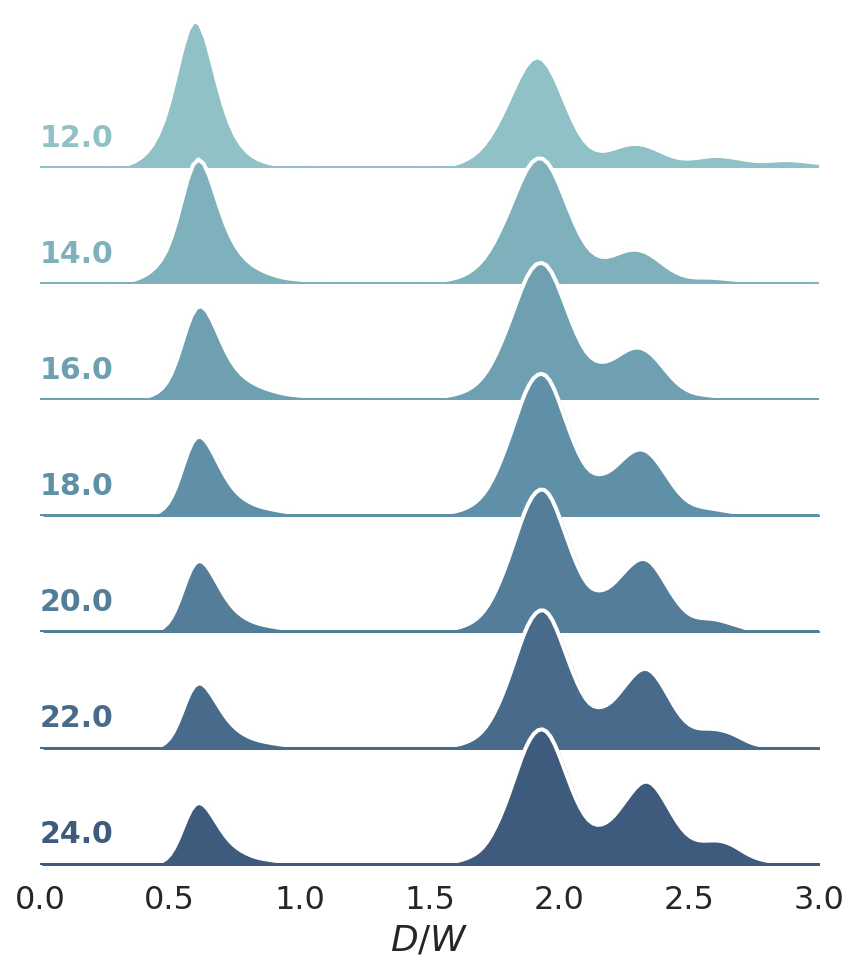

In [35]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

data_2 = data.copy()

data_2 = data_2[(data["time"] >= 12) & (data["time"] <= 24)]
data_2["diameter"] = data_2["diameter"].map(lambda p: p/2.0)

pal = sns.cubehelix_palette(10, rot=-.25, light=.7);
g = sns.FacetGrid(data_2, row="time", hue="time", aspect=6, height=1.0, palette=pal);

# Draw the densities in a few steps
g.map(sns.kdeplot, "diameter",
      bw_adjust=.5, clip_on=True,
      fill=True, alpha=1, linewidth=1.5);
g.map(sns.kdeplot, "diameter", clip_on=True, color="w", lw=2, bw_adjust=.5);
g.map(plt.axhline, y=0, lw=2, clip_on=True);


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca();
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes, fontsize=15);


g.map(label, "time");

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25);


# Remove axes details that don't play well with overlap
g.set_titles("");
g.set(yticks=[]);
g.set(xlim=(0.0,3.0));
plt.xlabel("$D/W$", fontsize=18);
plt.xticks(fontsize=16);
g.despine(bottom=True, left=True);
#g.fig.savefig("./plots_paper/pdf_vs_time.pdf", dpi=200);

## Nature of distribution near tail region

We take a closer look at the tail region of the histograms, for different slices of time. The steps in the analysis are 

- Error bars are computed for a fixed set of histogram bins, using a **bootstrapping** method (no assumptions about underlying distribution made !). 
- Bin heights and corresponding errors are rescaled by the total area under the histogram, in order to approximate a **PDF** . 
- A number of points starting from the end of the tail are chosen to carry out the fitting procedure. We mainly try to find a description for the *main* Rayleigh-Plateau peak.  
- Functions such as Gaussian, Log-Normal, Gamma, Poisson (volume based) and Pareto are fitted near the tail region, for the window of points chosen.


We can explore the fits based on 2 degrees of freedom, the first being the time slice chosen for the drop size distribution, the second being the number of points to fit in the window. 


### Select the time slice 
In our case, T=14 onwards are the interesting time slices. 

In [42]:
from useful_functions import *
d1 = time_slice(data, 14)
print("Total number of drops in this time slice is {}. ".format(len(d1[:,1])))

Total number of drops in this time slice is 138693. 


### Computing averaged heights and corresponding error bars for histogram
We can choose different bin sizes (uniform) by varying the `global_n_bins` variable in the code below.

In [43]:
global_n_bins = 30

heights = ensemble_heights(data=d1[:,1]/2.0, size_per_sample=100000, n_samples=100, n_bins= global_n_bins)

error_d1 = ensemble_error_heights(n_bootstrap=50, data=d1[:,1]/2.0, size_per_sample= 100000, n_samples=100, n_bins= global_n_bins)


### Fitting in the intermediate range

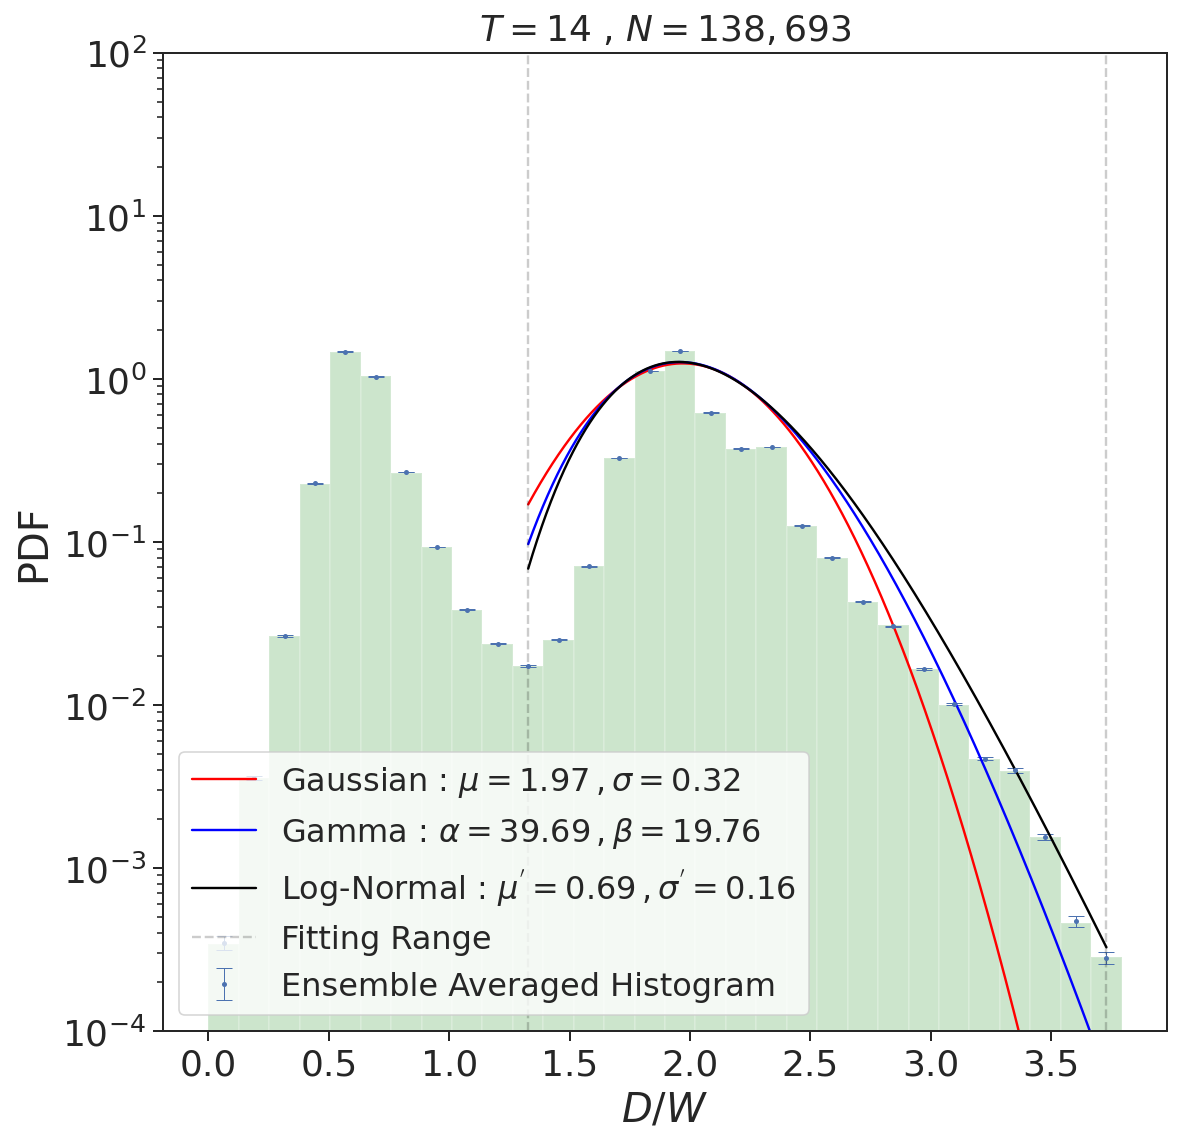

In [56]:
%matplotlib inline
fig = plt.figure(figsize=(9,9))

fit_x, fit_y, xspace = plot_histogram_error(data=d1[:,1]/2.0, n_bins= global_n_bins, 
                                                heights=heights, errors=error_d1);

# How many points from the tail end, starting from the tail end point, do you want to fit on. max points = 25
limit_1 = 20
limit_2 = 1

x_lim_test_1 = np.where( xspace >= fit_x[-limit_2])
x_lim_test_2 = np.where( xspace >= fit_x[-limit_1])

x_lim_1 = x_lim_test_2[0][1]
x_lim_2 = x_lim_test_1[0][1]

popt_gauss , pcov_gauss = fit(fit_x[-limit_1:-limit_2],fit_y[-limit_1:-limit_2], gauss)
plt.plot(xspace[x_lim_1:x_lim_2], gauss(xspace[x_lim_1:x_lim_2], *popt_gauss), 
         label="Gaussian : $\mu = %.2f \, ,  \sigma = %.2f$" %(popt_gauss[0], popt_gauss[1]), c='red' ); 

popt_gamma, pcov_gamma = fit(fit_x[-limit_1:-limit_2],fit_y[-limit_1:-limit_2], gamma_n)
plt.plot(xspace[x_lim_1:x_lim_2], gamma_n(xspace[x_lim_1:x_lim_2], *popt_gamma), 
         label=r"Gamma : $ \alpha = %.2f \, , \beta = %.2f$" %(popt_gamma[0],popt_gamma[1]), c='blue'); 

popt_lognorm, pcov_lognorm = fit(fit_x[-limit_1:-limit_2],fit_y[-limit_1:-limit_2], lognorm)
plt.plot(xspace[x_lim_1:x_lim_2], lognorm(xspace[x_lim_1:x_lim_2], *popt_lognorm), 
         label="Log-Normal : $\mu^{'} = %.2f \, , \sigma^{'} = %.2f$" %(popt_lognorm[0], popt_lognorm[1]), c='black'); 

#popt_poisson_2, pcov_poisson_2 = fit(fit_x[-limit_1:-limit_2],fit_y[-limit_1:-limit_2], poisson_2)
#plt.plot(xspace[x_lim_1:x_lim_2], poisson_2(xspace[x_lim_1:x_lim_2], *popt_poisson_2), 
#         label="Poisson : $\lambda = %.2f$" %popt_poisson_2[1]); 

#popt_pareto, pcov_pareto = fit(fit_x[-limit_1:-limit_2],fit_y[-limit_1:-limit_2], pareto)
#plt.plot(xspace[x_lim_1:x_lim_2], pareto(xspace[x_lim_1:x_lim_2], *popt_pareto), 
#         label="Pareto : $n = %.2f$" %popt_pareto[1]); 


plt.axvline(x = fit_x[-limit_1], color = 'black', linestyle='--', alpha = 0.2, label="Fitting Range")
plt.axvline(x = fit_x[-limit_2], color = 'black', linestyle='--', alpha = 0.2)

plt.hist(d1[:,1]/2.0, alpha = 0.2 , color= 'green', bins=bin_selection(d1[:,1]/2.0, global_n_bins)[0], density=True);

plt.title("$T=14$ , $N={:,}$".format(np.size(d1[:,1]/2.0)), fontsize=18);
plt.ylim(top = 1e2, bottom = 1e-4);
plt.yscale('log', basey = 10);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.xlabel("$D/W$" , fontsize=20);
plt.ylabel("PDF",fontsize=20);
plt.legend(fontsize=16, loc='lower left');

plt.savefig("./plots_paper/pdf_t14_log.pdf", dpi = 200);


### Fitting in the tail region
We can choose the number of points near the tail region for our window of fitting, using the `limit` variable in the code below.

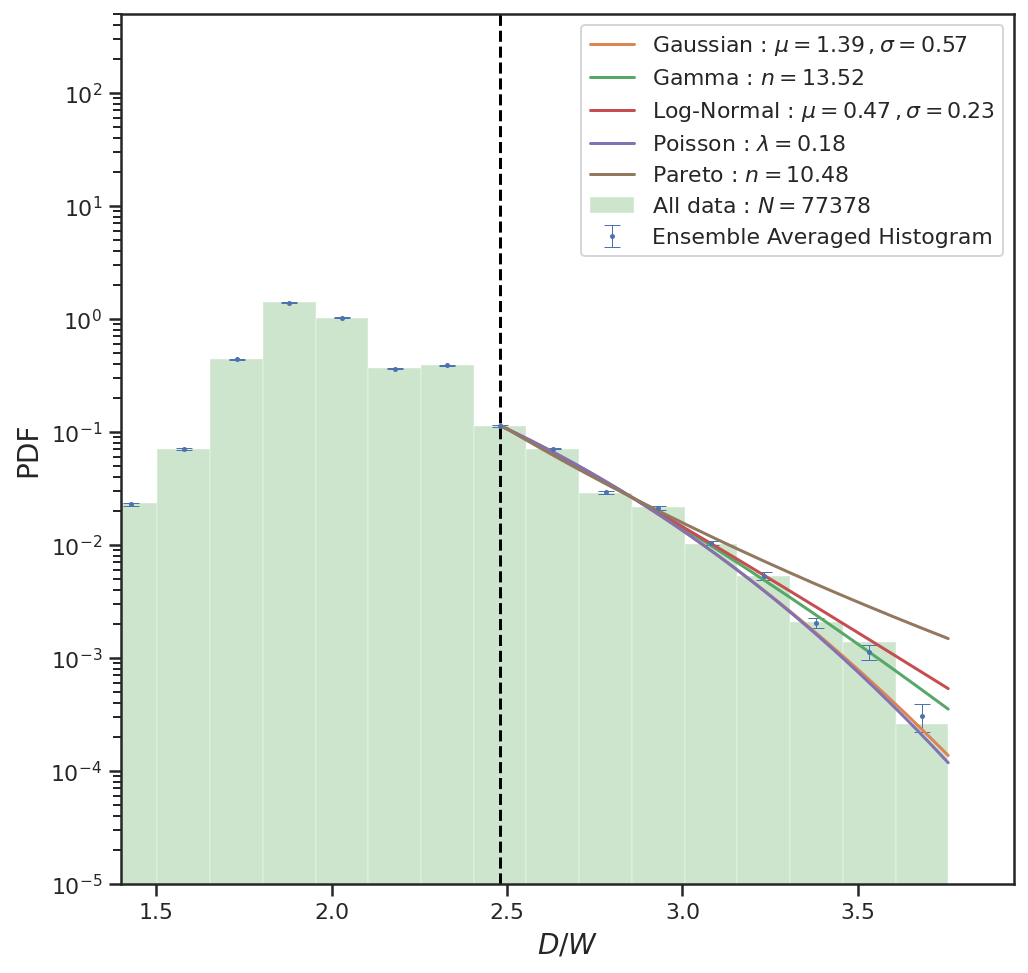

In [25]:
fig = plt.figure(figsize=(8,8))

fit_x, fit_y, xspace = plot_histogram_error(data=d1[:,1]/2.0, n_bins= global_n_bins, heights=heights, errors=error_d1)

# How many points from the tail end, starting from the tail end point, do you want to fit on. max points = 25
limit = 9

x_lim_test = np.where( xspace >= fit_x[-limit] )

x_lim = x_lim_test[0][1]

popt_gauss , pcov_gauss = fit(fit_x[-limit:],fit_y[-limit:], gauss)
plt.plot(xspace[x_lim:], gauss(xspace[x_lim:], *popt_gauss), 
         label="Gaussian : $\mu = %.2f \, ,  \sigma = %.2f$" %(popt_gauss[0], popt_gauss[1]) ); 

popt_gamma, pcov_gamma = fit(fit_x[-limit:], fit_y[-limit:], gamma_n)
plt.plot(xspace[x_lim:], gamma_n(xspace[x_lim:], *popt_gamma), 
         label="Gamma : $n = %.2f$" %(popt_gamma[0])); 

popt_lognorm, pcov_lognorm = fit(fit_x[-limit:], fit_y[-limit:], lognorm)
plt.plot(xspace[x_lim:], lognorm(xspace[x_lim:], *popt_lognorm), 
         label="Log-Normal : $\mu = %.2f \, , \sigma = %.2f$" %(popt_lognorm[0], popt_lognorm[1])); 

#popt_poisson, pcov_poisson = fit(fit_x[-limit:], fit_y[-limit:], poisson)
#plt.plot(xspace[x_lim:], poisson(xspace[x_lim:], *popt_poisson), label="Poisson : $\lambda = %.2f$" %popt_poisson[0]); 

popt_poisson_2, pcov_poisson_2 = fit(fit_x[-limit:], fit_y[-limit:], poisson_2)
plt.plot(xspace[x_lim:], poisson_2(xspace[x_lim:], *popt_poisson_2), 
         label="Poisson : $\lambda = %.2f$" %popt_poisson_2[1]); 

popt_pareto, pcov_pareto = fit(fit_x[-limit:], fit_y[-limit:], pareto)
plt.plot(xspace[x_lim:], pareto(xspace[x_lim:], *popt_pareto), 
         label="Pareto : $n = %.2f$" %popt_pareto[1]); 

plt.axvline(x = fit_x[-limit], color = 'black', linestyle='--')

plt.hist(d1[:,1]/2.0, alpha = 0.2, color= 'green', bins=bin_selection(d1[:,1]/2.0, global_n_bins)[0], 
         density=True, label = "All data : $N = %d$" %(np.size(d1[:,1]/2.0)))

plt.ylim(top = 5e2, bottom = 1e-5);
plt.xlim(left = 1.4)
plt.yscale('log', basey = 10);
plt.legend();

### Exponential fit at large sizes 
In order to take a closer look at the asymptotic behaviour at large sizes (near the tail end), we use a function as defined below -

$$ y = A \cdot \rm{exp}\left( -n \cdot x^m \right) \,.$$

Taking $\rm{log}$ twice on both side and rearranging, we obtain 

$$  Y = m \cdot X + C , \quad \text{where} \quad Y = \rm{log}(- \rm{log}(y/A)) \quad \text{and} \quad X= \rm{log}(x) \,.$$

Now, we replot the tail end of the histogram on this new scale as defined above, and find the best fit corresponding to our candidate function. We choose the number of points near the tail region for our fitting window, using the `new_limit` variable in the code below. 

The value of m is 3.23, with a 95% confidence interval of [3.18-3.29]



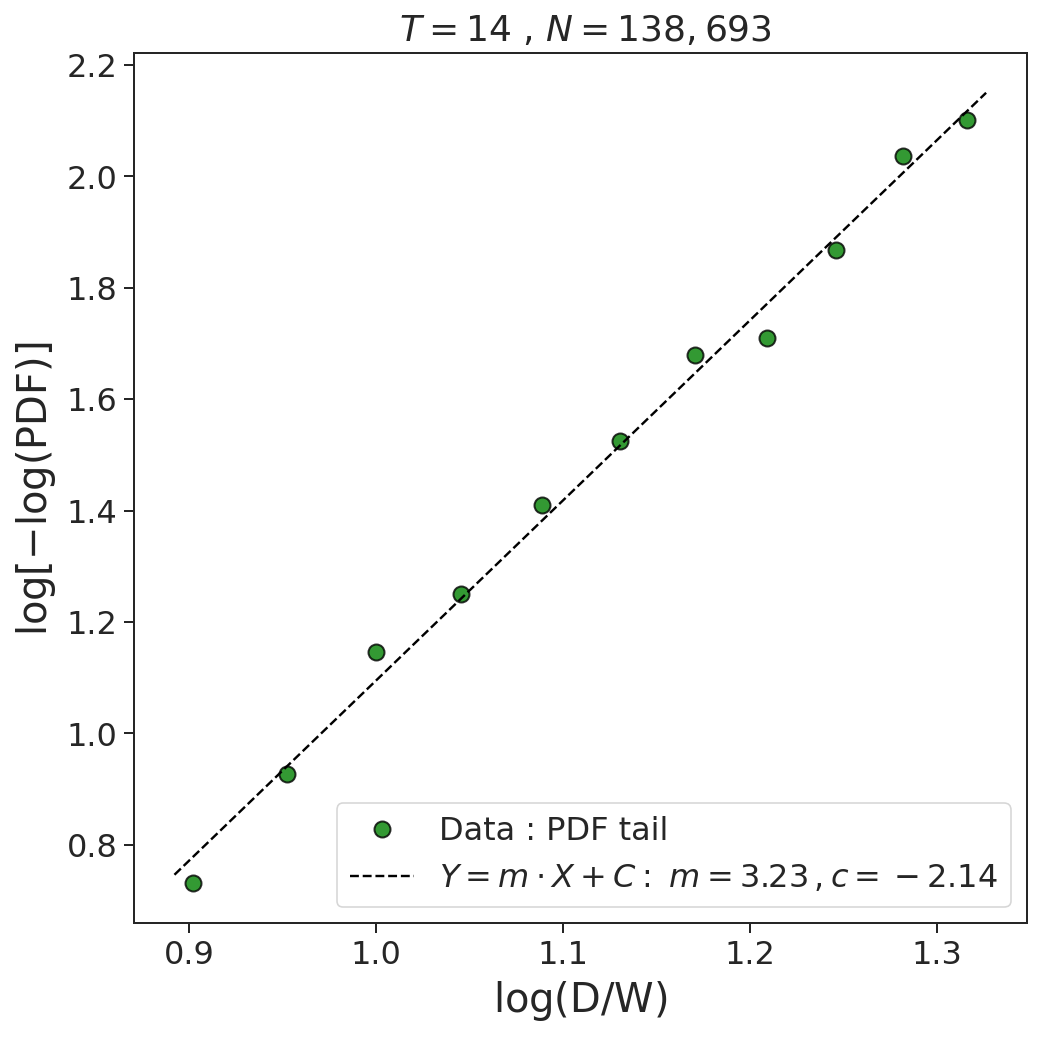

In [55]:
new_limit = 11

X = np.log(fit_x[-new_limit:])
Y = np.log(-1.0 * np.log(fit_y[-new_limit:]))

log_xspace = np.linspace(np.amin(X)- 1e-2 , np.amax(X)+1e-2, 1000)

popt_linear , pcov_linear = fit(X,Y, linear)


fit_error = np.sqrt(np.diag(pcov_linear))

standard_fit_error = fit_error[0]/np.sqrt(new_limit)

m_fit = popt_linear[0]
bound_1 = popt_linear[0] - 1.96 * standard_fit_error
bound_2 = popt_linear[0] + 1.96 * standard_fit_error

print("The value of m is {0:.2f}, with a 95% confidence interval of [{1:.2f}-{2:.2f}]\n".format(m_fit, bound_1, bound_2))

plt.figure(figsize=(8,8));

plt.plot(X,Y, linestyle='', marker='o', markersize=8, markeredgecolor='black', 
         label="Data : PDF tail", markerfacecolor='green', alpha = 0.8);

plt.plot(log_xspace, linear(log_xspace, *popt_linear), linestyle = '--', color = 'black',  
         label="$Y = m \cdot X + C :$ $m = %.2f \, , c = %.2f$" %(popt_linear[0], popt_linear[1]),);

plt.title(" $T=14$ , $N={:,}$".format(np.size(d1[:,1]/2.0)), fontsize=18);

plt.xlabel(r'$\rm{log} \left(D/W \right)$', fontsize = 20);
plt.ylabel(r'$\rm{log}\left[ - \rm{log} \left( \rm{PDF} \right) \right]$', fontsize=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.legend(fontsize=16, loc = "lower right");

plt.savefig("./plots_paper/pdf_t14_tail.pdf", dpi=200);



### Power law fit at large sizes
Let us also check whether the tail region can also be fitted with a power law type function, such as 

$$ y = A\cdot x^{-n} \,.$$

We take $\textrm{log}$ on both sides, so now we are replotting the tail end of our histogram on scales $X$ and $Y$, where

$$ Y = C - n\cdot X \quad  \text{where,} \quad X = \textrm{log}(x) \quad \text{and} \quad Y = \textrm{log}(y) \,.$$

The value of m is 16.06, with a 95% confidence interval of [16.84-15.28]



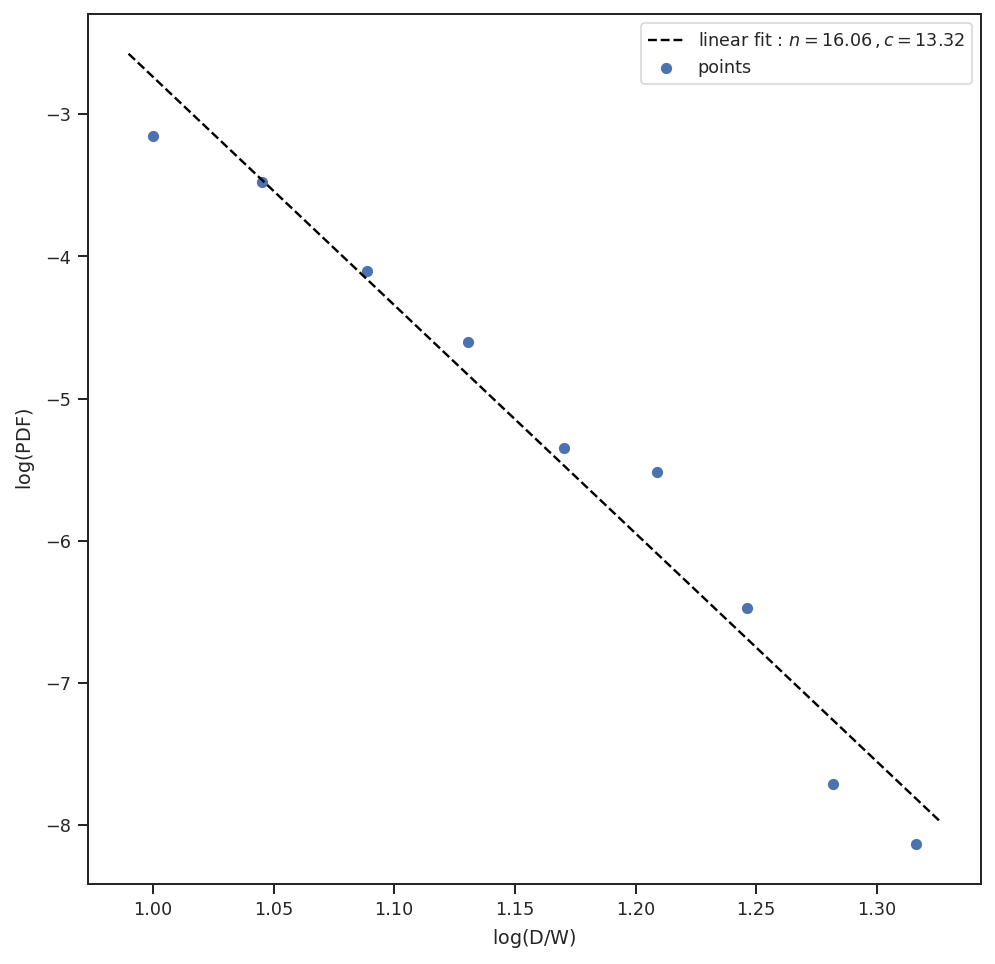

In [227]:
new_limit = 9

X = np.log(fit_x[-new_limit:])
Y = np.log(fit_y[-new_limit:])

log_xspace = np.linspace(np.amin(X)- 1e-2 , np.amax(X)+1e-2, 1000)

popt_linear , pcov_linear = fit(X,Y, linear)

fit_error = np.sqrt(np.diag(pcov_linear))

standard_fit_error = fit_error[0]/np.sqrt(new_limit)

m_fit = popt_linear[0]
bound_1 = popt_linear[0] - 1.96 * standard_fit_error
bound_2 = popt_linear[0] + 1.96 * standard_fit_error

print("The value of m is {0:.2f}, with a 95% confidence interval of [{1:.2f}-{2:.2f}]\n".format(-m_fit, -bound_1, -bound_2))

plt.figure(figsize=(8,8))
plt.scatter(X,Y,label="points");
plt.plot(log_xspace, linear(log_xspace, *popt_linear), linestyle = '--', color = 'black',  
         label="linear fit : $n = %.2f \, , c = %.2f$" %(-popt_linear[0], popt_linear[1]));
plt.xlabel(r'$\rm{log}(D/W)$');
plt.ylabel(r'$\rm{log}(\rm{PDF})$');
plt.legend();



## Ohnesorge vs. Weber 
We want to observe how the Ohnesorge and Weber numbers for each drop in the ensemble are correlated. First we need to find the *length* scale of our problem (at 20 degrees Celcius).

### Definition of air-water properties 

In [23]:
def compute_length(Oh = 1e-2):
    # properties of air-water system at 20 degrees Celcius
    mu = 1.002e-3
    sigma = 72.86e-3
    rho = 998.19

    return (mu**2.0) / (rho * sigma * Oh**2.0)
    

print("The radius R is {:.2f} mm".format(1000.0*compute_length(0.0037)))

The radius R is 1.01 mm


### Generating Oh and We numbers


In [28]:
#length_scale = (mu**2.0) / (rho * sigma * Oh**2.0)

length_scale = compute_length()

# rescaling our diameters by length scale
data_3 = data.copy()
data_3 = data_3[data["time"] >=14]
data_3["diameter"] = data_3["diameter"].map(lambda p: p*length_scale)
data_3["Ohnesorge"] = (mu/np.sqrt(rho * sigma * data_3["diameter"]))
data_3["velocity"] = data_3["velocity"].map(lambda p: float(p))
data_3["Weber"] = (rho * data_3["velocity"]**2.0 * data_3["diameter"]) / sigma
data_3.head()

,time,diameter,velocity,Ohnesorge,Weber
22,14.0,0.000546,-0.11758,0.005028,0.103438
23,14.0,0.000319,-0.59950,0.006575,1.572450
24,14.0,0.000658,0.17104,0.004581,0.263630
25,14.0,0.000506,0.07957,0.005221,0.043923
26,14.0,0.000165,0.31059,0.009160,0.217418


In [29]:
data_3.Ohnesorge.describe()
data_3.Weber.describe()

count    522692.000000
mean          0.006049
std           0.001843
min           0.003648
25%           0.004808
50%           0.005108
75%           0.008063
max           0.021430
Name: Ohnesorge, dtype: float64

count    522692.000000
mean          0.406595
std           8.467385
min           0.000000
25%           0.020285
50%           0.091827
75%           0.283860
max        1007.021518
Name: Weber, dtype: float64

In [30]:
data_3.plot(kind="scatter", x = "Ohnesorge" , y = "Weber" , c = "time", colormap = "jet", 
            colorbar= True, alpha = 0.1 , s = data_3["diameter"]*1e6, figsize=(10,8));
#plt.xscale('log', basex = 10); 
#plt.yscale('log', basey = 10);
plt.ylim(top=20, bottom = 0);
plt.xlim(right = 0.02, left = 0.0);
plt.xlabel("Ohnesorge");
plt.ylabel("Weber");
#plt.xscale("log", basex=10)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [33]:
data_3.hist("Ohnesorge", bins=50);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …